# Multi-Target Image Classification

The goal of this project is to classify an image of a face by age range, gender, and race.  The data used for the project is the UTKFace dataset.

UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc.

The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age
[gender] is either 0 (male) or 1 (female)
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

## Pre-Processing

In [2]:
# Load packages
import numpy as np 
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [3]:
# Create constants and dictionaries
DATA_DIR = "./UTKFace"
TEST_DIR = "./TEST"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 200
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())
ID_AGE_MAP = {0:'-18', 1:'18-24', 2:'25-34', 3: '35-44', 4:'45-54', 5:'55-64', 6:'65-75', 7:'75+'}
AGE_ID_MAP = dict((a, i) for i, a in ID_AGE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP, ID_AGE_MAP, AGE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4},
 {0: '-18',
  1: '18-24',
  2: '25-34',
  3: '35-44',
  4: '45-54',
  5: '55-64',
  6: '65-75',
  7: '75+'},
 {'-18': 0,
  '18-24': 1,
  '25-34': 2,
  '35-44': 3,
  '45-54': 4,
  '55-64': 5,
  '65-75': 6,
  '75+': 7})

In [122]:
# extract the demographic information from the file name
def parse_filename(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None
    
# save figures throughout the notebook into your pwd.
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [33]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))
test_files = glob.glob(os.path.join(TEST_DIR,"*.jpg"))
attributes = list(map(parse_filename, files))
test_attributes = list(map(parse_filename, test_files))
#Train/val df
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()
# test df
df_test = pd.DataFrame(test_attributes)
df_test['file'] = test_files
df_test.columns = ['age', 'gender', 'race', 'file']
df_test.sample(4)

# Exploratory analysis

In [36]:
# Center and spread of numerical variables. 
df.describe()

,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


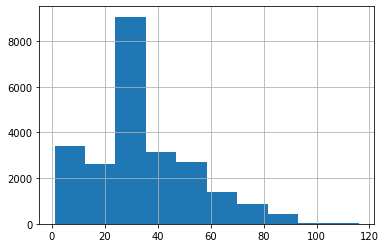

In [41]:
# General age distribution Histogram
df['age'].hist()

In [37]:
# Which race contributes to most of the elderly pictures?
df.loc[df['age']>75].groupby("race").count()

,age,gender,file
race,,,
asian,138,138,138
black,82,82,82
indian,29,29,29
others,5,5,5
white,597,597,597


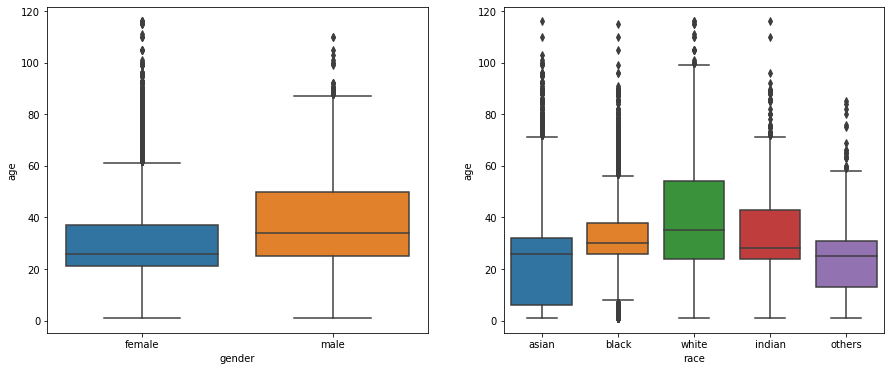

In [38]:
# Boxplots of age by gender and race.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

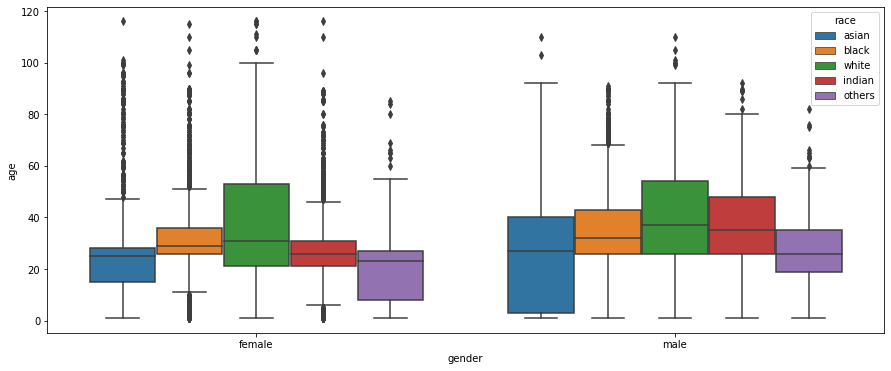

In [39]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

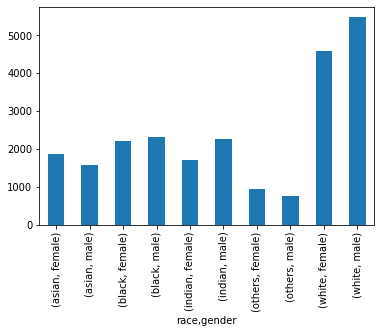

In [40]:
# Bar plot of count grouped by race and gender. 
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')


It turns out that there are many images of white individuals compared to the other category.

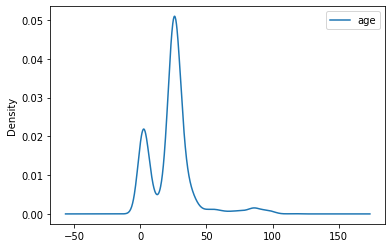

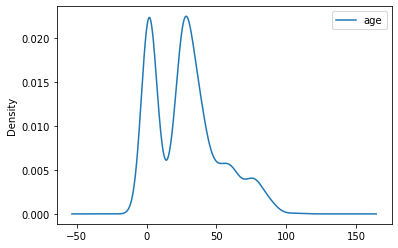

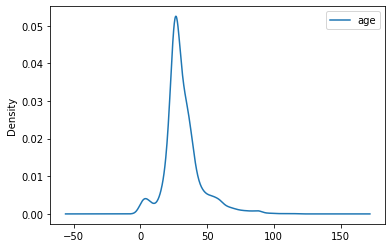

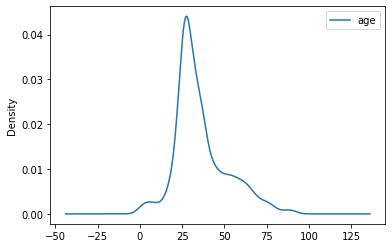

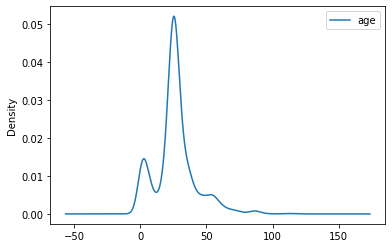

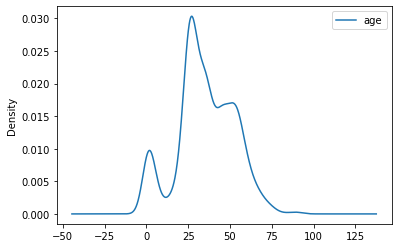

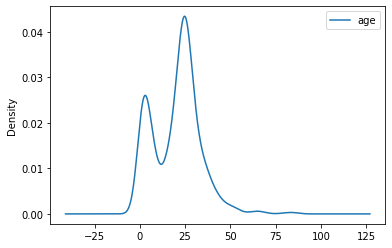

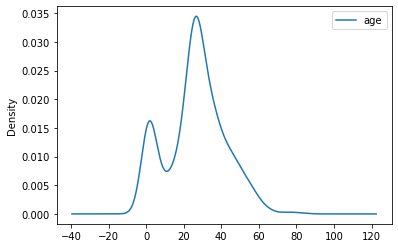

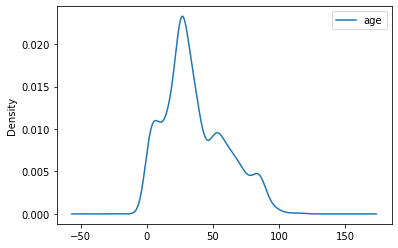

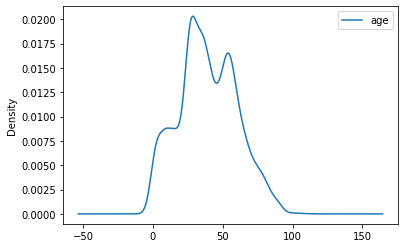

In [42]:
#show the density distribution of age for race and gender
df.groupby(['race', 'gender']).plot(kind='density')
plt.legend()

There are a lot of pictures of babies around 1 years old, in most subgroups.  Also, there are a lot of pictures of people in their mid 20s.  Since we're not interested in targeting very young individuals anyway, we'll get rid of pictures under the age of 7.  In order to balance the dataset better, we'll turn the continuous age variable into a categorical variable and try to make the bins even for age category, race, and gender, but not necessarily all together at once.


We'll have to stratify the sampling for our train/test split and undersample the caucasian subgroups to better match the size of the others. Since our main focus isn't the minority class, balancing the dataset isn't super critical, but in order not to train the model with a significant bias toward one race or another, we thought it would still be beneficial. 

In [44]:
#Getting rid of under 7 years old. 
df = df[df['age'] > 6]  

#Keeping a random sampling of 50% of the white images. 
white_keep = df.loc[df['race']=='white'].sample(frac=0.5, replace=False, random_state=1)
df = pd.concat([df.loc[df['race']!='white'], white_keep], axis = 0)

In [45]:
#Creating an Age Class categorical variable. 

def make_age_class(dataFrame):
    age_class = []
    for i in dataFrame['age']:
        i = int(i)
        if i < 18:
            age_class.append('-18')
        elif (18<=i<=24):
            age_class.append('18-24')
        elif (25<=i<=34):
            age_class.append('25-34')
        elif (35<=i<=44):
            age_class.append('35-44')
        elif (45<=i<=54):
            age_class.append('45-54')
        elif (55<=i<=64):
            age_class.append('55-64')
        elif (65<=i<=75):
            age_class.append('65-75')
        else:
            age_class.append('75+')
    return(age_class)

# creating age class for df and df_test
# Age groups = [‘-18',’18-24', '25-34', '35-44','45-54', '55-64', '65-75', '75+’]
df['age_class'] = make_age_class(df)
df = df[['age_class','gender', 'race', 'file', 'age']] #changing column order
df_test['age_class'] = make_age_class(df_test)
df_test = df_test[['age_class','gender', 'race', 'file', 'age']]


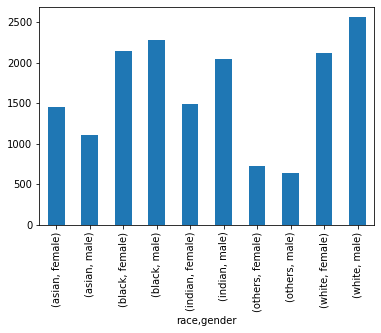

In [46]:
#checking new distribution of counts by gender and race.
df.groupby(['race', 'gender'])['age_class'].count().plot(kind='bar')


In [47]:
# Checking counts just by race.
df.groupby(['race'])['age_class'].count()

race
asian     2560
black     4414
indian    3535
others    1356
white     4673
Name: age_class, dtype: int64

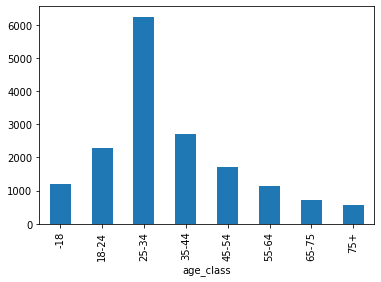

In [48]:
#checking distribution of race and age_class.
df.groupby(['age_class'])['gender'].count().plot(kind='bar')

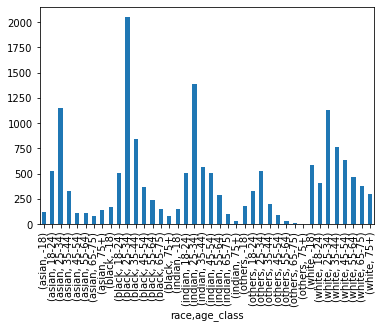

In [49]:
#checking distribution of race and age_class.
df.groupby(['race', 'age_class'])['gender'].count().plot(kind='bar')

## OPTIONAL!: Undersample at Max to Balance

In [ ]:
#Keeping a random sampling of 60% of the white images. 
white_keep = df.loc[df['race']=='white'].sample(frac=0.6, replace=False, random_state=1)
df = pd.concat([df.loc[df['race']!='white'], white_keep], axis = 0)
#Keeping a random sampling of 62.5% of the black images. 
black_keep = df.loc[df['race']=='black'].sample(frac=0.625, replace=False, random_state=1)
df = pd.concat([df.loc[df['race']!='black'], black_keep], axis = 0)
#Keeping a random sampling of 75% of the indian images. 
indian_keep = df.loc[df['race']=='indian'].sample(frac=0.75, replace=False, random_state=1)
df = pd.concat([df.loc[df['race']!='indian'], indian_keep], axis = 0)

In [ ]:
# New distribuition of count by race and gender.
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')


In [ ]:
#Keeping a random sampling of 75% of the indian images. 
age_keep = df.loc[df['age_class']=='25-34'].sample(frac=0.5, replace=False, random_state=1)
df = pd.concat([df.loc[df['age_class']!='25-34'], age_keep], axis = 0)

In [ ]:
# New distribution of counts by age class.
df.groupby(by=['age_class'])['gender'].count().plot(kind='bar')


# Data prep

80% Train 20% Valid; Separate folder of 64 pictures for test.

In [ ]:
# stratified shuffle split stratified by gender.
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_index, valid_index in split.split(df, df['gender']):
    print("TRAIN:", train_index, "TEST:", valid_index)
    train_idx = train_index
    valid_idx = valid_index
    
# Concatenate df and test df for getting test index purpose
df = pd.concat([df, df_test], axis=0, sort=False).reset_index(drop=True)

# get last 64 indexes
test_idx = np.array(df.iloc[-64:].index.values.tolist())

In [ ]:
# Uncomment if you want to make a train/val/test from one folder instead.

#p = np.random.permutation(len(df))
#train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
#train_idx = p[:train_up_to]
#test_idx = p[train_up_to:]

# split train_idx further into training and validation set
#train_up_to = int(train_up_to * 0.7)
#train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]


In [51]:
# Make coded columns for gender, race, and age.
df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])
df['age_id'] = df['age_class'].map(lambda age_class: AGE_ID_MAP[age_class])

len(train_idx), len(valid_idx), len(test_idx)

(8103, 3473, 4962)

In [52]:
from keras.utils import to_categorical
from PIL import Image

# custom data generator
def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age_class, race, gender = r['file'], r['age_id'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(to_categorical(age_class, len(AGE_ID_MAP)))
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

Using TensorFlow backend.


Note:  Age range is being treated as a categorical variable here.  To change that to ordinal, perhaps represent the relationship of A<B<C with A as [1,0,0], B as [1,1,0], and C as [1,1,1].

# Model training

NOTE:  **Run ONE** of the model cells below and then skip to "Run Models From Here"

In [ ]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout, LeakyReLU
from keras.optimizers import SGD
from keras.models import Model

## Model1: ReLU with (Conv -> BatchNorm -> MaxPool) * range(3,7)

In [53]:
# Create model architecture
def conv_block(inp, filters=32, bn=True, pool=True):
    layer = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        layer = BatchNormalization()(layer)
    if pool:
        layer = MaxPool2D()(layer)
    return layer

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
layer = conv_block(input_layer, filters=32, bn=False, pool=False)
layer = conv_block(layer, filters=32*3)
layer = conv_block(layer, filters=32*4)
layer = conv_block(layer, filters=32*5)
layer = conv_block(layer, filters=32*6)
layer = conv_block(layer, filters=32*7)
bottleneck = GlobalMaxPool2D()(layer)


# for age calculation
layer = Dense(units=128, activation='relu')(bottleneck)
layer = Dropout(0.5)(layer)
age_output = Dense(units=len(AGE_ID_MAP), activation='softmax', name='age_output')(layer)

# for race prediction
layer = Dense(units=128, activation='relu')(bottleneck)
layer = Dropout(0.5)(layer)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(layer)

# for gender prediction
layer = Dense(units=128, activation='relu')(bottleneck)
layer = Dropout(0.5)(layer)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(layer)

model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='adam', 
              loss={'age_output': 'categorical_crossentropy', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'accuracy', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


## Model2: LeakyReLU (Conv -> BatchNorm -> MaxPool)*range(3,6)

In [ ]:
# Create model architecture
def conv_block(inp, filters=32, bn=True, pool=True, activation = True):
    layer = Conv2D(filters=filters, kernel_size=3)(inp)
    if bn:
        layer = BatchNormalization()(layer)
    if pool:
        layer = MaxPool2D()(layer)
    if activation:
        layer = LeakyReLU(alpha=0.05)(layer)
    return layer

input_layer = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
layer = conv_block(input_layer, filters=32, bn=False, pool=False)
layer = conv_block(layer, filters=32*3)
layer = conv_block(layer, filters=32*4)
layer = conv_block(layer, filters=32*5)
layer = conv_block(layer, filters=32*6)
layer = conv_block(layer, filters=32*6)
bottleneck = GlobalMaxPool2D()(layer)


# for age calculation
layer = Dense(units=128)(bottleneck)
layer = LeakyReLU(alpha=0.05)(layer)
layer = Dropout(0.5)(layer)
age_output = Dense(units=len(AGE_TO_ID), activation='softmax', name='age_output')(layer)

# for race prediction
layer = Dense(units=128)(bottleneck)
layer = LeakyReLU(alpha=0.05)(layer)
layer = Dropout(0.5)(layer)
race_output = Dense(units=len(RACE_TO_ID), activation='softmax', name='race_output')(layer)

# for gender prediction
layer = Dense(units=128)(bottleneck)
layer = LeakyReLU(alpha=0.05)(layer)
layer = Dropout(0.5)(layer)
gender_output = Dense(units=len(GENDER_TO_ID), activation='softmax', name='gender_output')(layer)


model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])

model.compile(optimizer='adam', 
              loss={'age_output': 'categorical_crossentropy', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'accuracy', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
model.summary()

## Model3: LeakyReLU: Dropout in between ConvNet, 1 less conv_block and 1 additional dense.

In [ ]:
# Create model architecture
def conv_block(inp, filters=32, bn=True, pool=True, activation = True):
    layer = Conv2D(filters=filters, kernel_size=3)(inp)
    if bn:
        layer = BatchNormalization()(layer)
    if pool:
        layer = MaxPool2D()(layer)
    if activation:
        layer = LeakyReLU(alpha=0.05)(layer)
    return layer

input_layer = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
layer = conv_block(input_layer, filters=32, bn=False, pool=False)
layer = conv_block(layer, filters=32*2)
layer = conv_block(layer, filters=32*3)
layer = conv_block(layer, filters=32*4)
layer = conv_block(layer, filters=32*5)
layer = conv_block(layer, filters=32*5)
bottleneck = GlobalMaxPool2D()(layer)


# for age calculation
layer = Dense(units=128)(bottleneck)
layer = LeakyReLU(alpha=0.05)(layer)
layer = Dropout(0.3)(layer)
layer = Dense(units=128, activation='relu')(layer)
age_output = Dense(units=len(AGE_TO_ID), activation='softmax', name='age_output')(layer)

# for race prediction
layer = Dense(units=128)(bottleneck)
layer = LeakyReLU(alpha=0.05)(layer)
layer = Dropout(0.3)(layer)
layer = Dense(units=128, activation='relu')(layer)
race_output = Dense(units=len(RACE_TO_ID), activation='softmax', name='race_output')(layer)

# for gender prediction
layer = Dense(units=128)(bottleneck)
layer = LeakyReLU(alpha=0.05)(layer)
layer = Dropout(0.3)(layer)
layer = Dense(units=128, activation='relu')(layer)
gender_output = Dense(units=len(GENDER_TO_ID), activation='softmax', name='gender_output')(layer)


model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])

model.compile(optimizer='adam', 
              loss={'age_output': 'categorical_crossentropy', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'accuracy', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
model.summary()

## Model4: Transfer Learning with ResNet50

In [ ]:
#import ResNet
from keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(200, 200, 3))

In [ ]:
# Create Model Architecture
def conv_block(inp, filters=32, bn=True, pool=True):
    layer = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        layer = BatchNormalization()(layer)
    if pool:
        layer = MaxPool2D()(layer)
    return layer

input_layer = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
layer = conv_base(input_layer)
bottleneck = GlobalMaxPool2D()(layer)


# for age calculation
layer = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=len(AGE_TO_ID), activation='softmax', name='age_output')(layer)

# for race prediction
layer = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_TO_ID), activation='softmax', name='race_output')(layer)

# for gender prediction
layer = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_TO_ID), activation='softmax', name='gender_output')(layer)


model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='adam', 
              loss={'age_output': 'categorical_crossentropy', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'accuracy', 'race_output': 'accuracy', 'gender_output': 'accuracy'})

# set resnet50 parameters to be constant (not trainable)
conv_base.trainable = False

model.summary()


# Run Models From Here

In [ ]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# save the model picture
plot_model(model, to_file='.png')# Change Name!

In [55]:
from keras.callbacks import ModelCheckpoint

batch_size = 20  #modify if necessary for speed
valid_batch_size = 20  #modify if necessary
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=1,  #change number of epochs
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)
                    


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1
405/405 [==============================] - 3413s 8s/step - loss: 6.0701 - age_output_loss: 1.7922 - race_output_loss: 1.2887 - gender_output_loss: 0.5527 - age_output_acc: 0.3553 - race_output_acc: 0.4974 - gender_output_acc: 0.7280 - val_loss: 5.6249 - val_age_output_loss: 1.6793 - val_race_output_loss: 1.1947 - val_gender_output_loss: 0.4741 - val_age_output_acc: 0.3977 - val_race_output_acc: 0.5396 - val_gender_output_acc: 0.7705


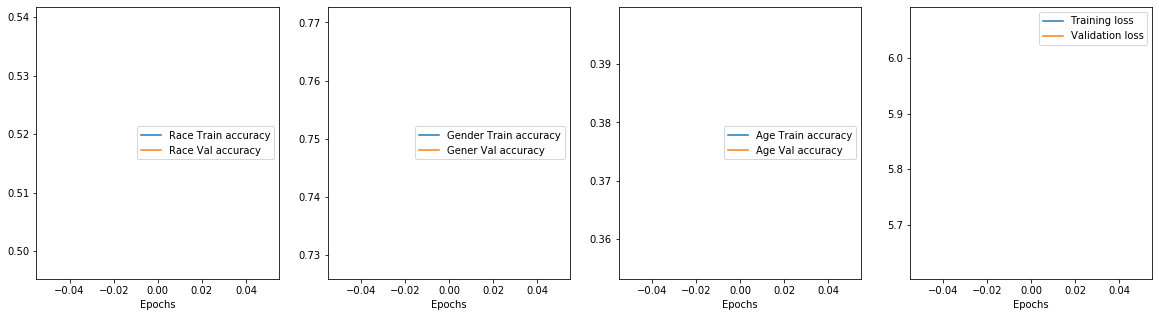

In [123]:
# Plot the model accuracy for each epoch.
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_acc'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_acc'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_acc'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_acc'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_acc'], label='Age Train accuracy')
    axes[2].plot(history.history['val_age_output_acc'], label='Age Val accuracy')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)
save_fig('modelX_accuracy') #CHANGE X NAME of image title for each model.


In [61]:
# Results summary
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=32)  #batch_size=128
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//32))) #steps=len(test_idx)//128))


KeyboardInterrupt: 

In [112]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))


ModuleNotFoundError: No module named 'sklearn'

# Test Predictions

In [ ]:
# Uncomment if you want to create a Face (Y/N) boolean later

#def makeJSON1(keys,races,genders,ages):
#    def helper(isface,age,gender,race):
#        if isface:
#            return {"age": age, "gender": gender, "race": race}
#        else:
#            return {}
#    return {i:{"isface": True, "appearance": helper(True,j,k,l)} for i,j,k,l in zip(keys,races,genders,ages)}


In [62]:
# Function to make a nested dictionary of predictions
def makeJSON2(keys,races,genders,ages):
    return {i:{"appearance": {"age": l, "gender": k, "race": j}}for i,j,k,l in zip(keys,races,genders,ages)}

In [118]:
batchSize=32

# Create empty lists of predictions and true values
gender_pred_list, age_pred_list, race_pred_list = [], [], []
age_true_list, race_true_list, gender_true_list = [], [], []
x_test_list = []


test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=batchSize)
#for i in range(len(test_idx)//batchSize):
for i in range(2):
    x_test, (age_true, race_true, gender_true) = next(test_gen)
    # predict values encoded
    age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)
    race_pred, gender_pred, age_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1), age_pred.argmax(axis=-1)
    race_true, gender_true, age_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1), age_true.argmax(axis=-1)
    # de-encode prediction values
    race_pred = pd.Series(race_pred).map(lambda race:  ID_RACE_MAP[race])
    age_pred = pd.Series(age_pred).map(lambda age:  ID_AGE_MAP[age])
    gender_pred = pd.Series(gender_pred).map(lambda gender:  ID_GENDER_MAP[gender])
    # de-encode true values
    race_true = pd.Series(race_true).map(lambda race:  ID_RACE_MAP[race])
    age_true = pd.Series(age_true).map(lambda age:  ID_AGE_MAP[age])
    gender_true = pd.Series(gender_true).map(lambda gender:  ID_GENDER_MAP[gender])
    
    # append to lists
    list(map(lambda gender: gender_pred_list.append(gender), gender_pred))
    list(map(lambda age: age_pred_list.append(age), age_pred))
    list(map(lambda race: race_pred_list.append(race), race_pred))
    list(map(lambda x_t: x_test_list.append(x_t), x_test))
    list(map(lambda age_t: age_true_list.append(age_t), age_true))
    list(map(lambda race_t: race_true_list.append(race_t), race_true))
    list(map(lambda gender_t: gender_true_list.append(gender_t), gender_true))

# Make a nested dictionary to make into JSON file later.
pred_keys = range(len(gender_pred_list))
pred_dict = makeJSON2(pred_keys, race_pred_list, gender_pred_list, age_pred_list)   
    

## Save the prediction values into JSON file

In [97]:
# turn the dictionary into a JSON file.
import json
#json.dumps(pred_dict)
with open("prediction_result.json","w") as f:
    json.dump(pred_dict,f)

## Visualizing some of the test set predictions

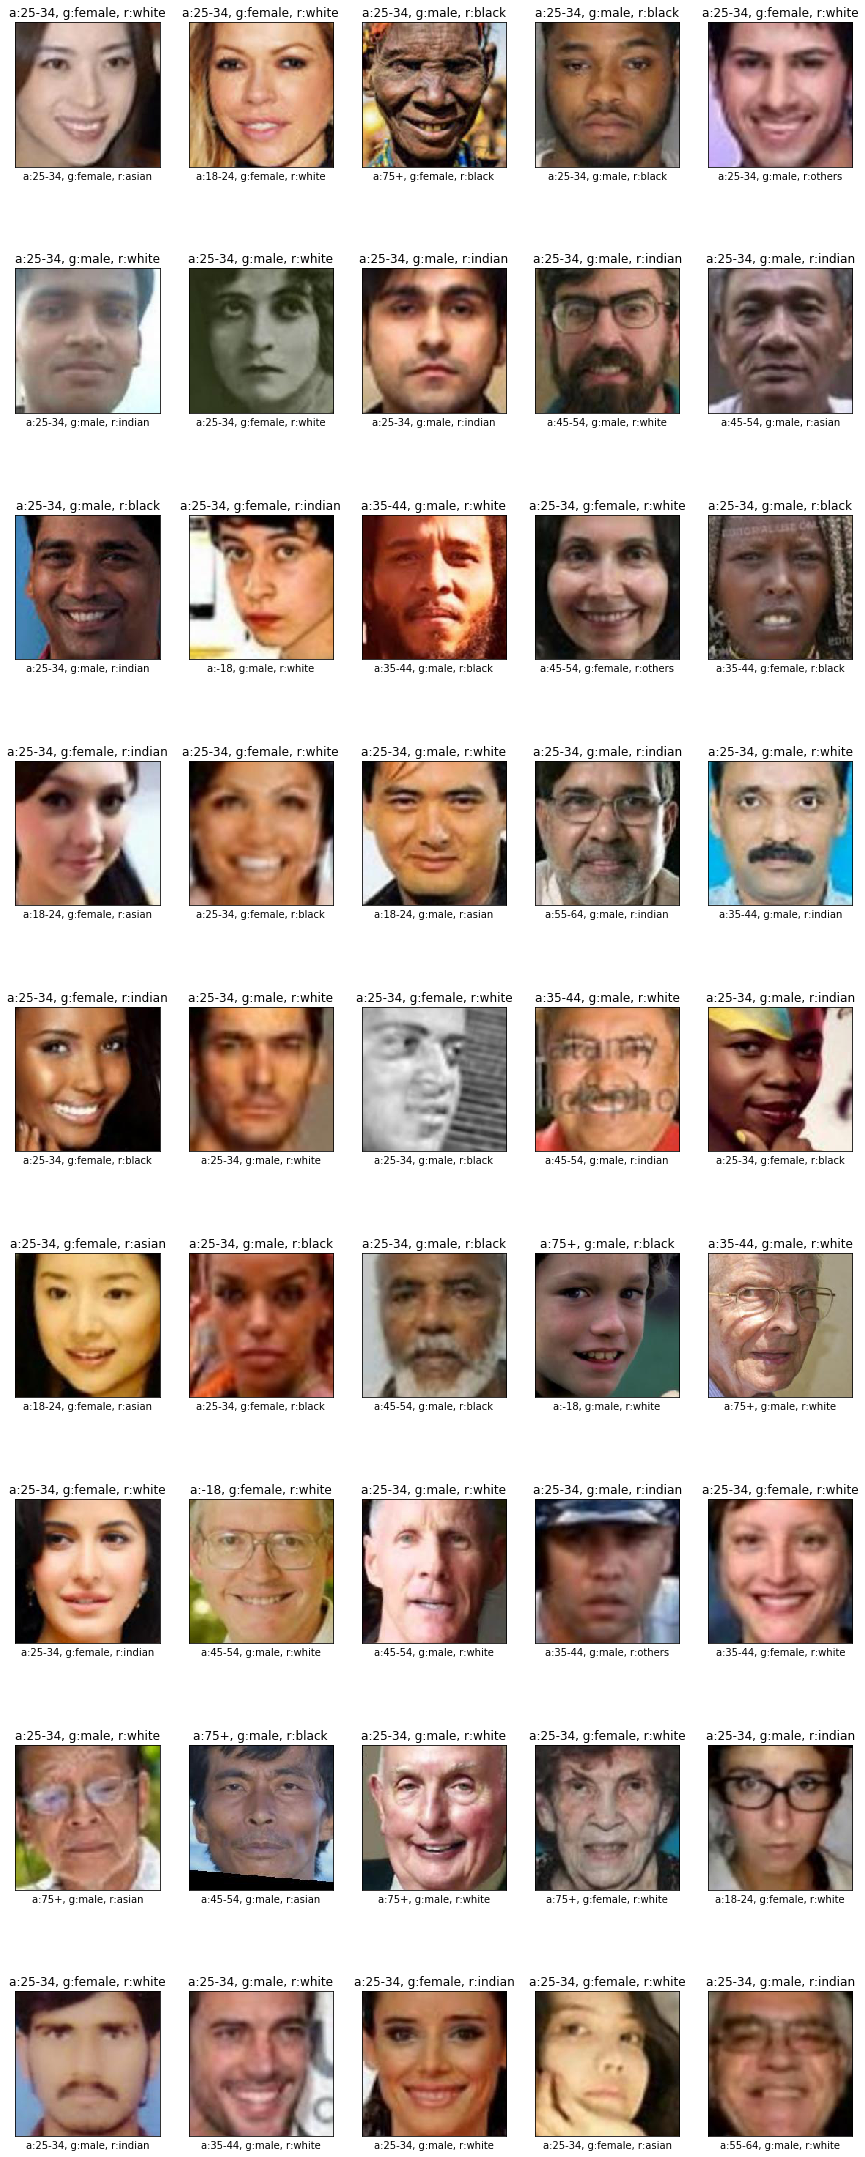

In [124]:
import math
n = 45
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 40))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test_list[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(age_pred_list[img_idx], gender_pred_list[img_idx], race_pred_list[img_idx]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(age_true_list[img_idx], gender_true_list[img_idx], race_true_list[img_idx]))
    ax.set_xticks([])
    ax.set_yticks([])

#save output images
save_fig('test_output')
